In [1]:
import numpy as np
from matplotlib import pyplot as plt
from hypergraph import hypergraph, read
plt.style.use('dark_background')

In [2]:
data = 'contact-high-school'
path = data + '/' + data + '-'

In [3]:
t_min = 1386330122

C = read.read_data(data, t_min = t_min)
C = hypergraph.hypergraph(C)
G = hypergraph.projected_graph(C, as_hyper = True)

In [4]:
def adjacency_matrix(G):
    A = np.zeros((G.n, G.n))
    for f in G.C:
        A[f[0], f[1]] += 1
        A[f[1], f[0]] += 1
    return(A)

In [5]:
G.n, G.m

(268, 10026)

In [36]:
# def sample_round(G, n_stub, n_vertex):
#     G.MH(label = 'stub', n_steps = n_stub, verbose = False, message = False)
#     G.MH(label = 'vertex', n_steps = n_vertex, n_clash=1, verbose = False, message = False)
#     print('acceptance rate = ' + str(round(G.acceptance_rate, 4)))

def experiment(G, n_stub, n_vertex, n_rounds, sample_after, message_every = 100):
    
    w = np.zeros((G.n, G.n))
    x = np.zeros((G.n, G.n))
    w2 = np.zeros((G.n, G.n))
    
    G.MH(label = 'stub', n_steps = n_stub, verbose = False, message = False)
    print('Completed stub-labeled MCMC with ' + str(int(n_stub)) + ' steps.')
    
    for i in range(n_rounds + sample_after):
        G.MH(label = 'vertex', n_steps = n_vertex, verbose = False, message = False)
        if i % message_every == 0:
            print("Round " + str(i) + " of " + str(n_rounds + sample_after) + ' completed, ' + str(int(i * n_vertex)) + ' steps taken, acceptance rate = ' + str(round(G.acceptance_rate, 4)))
        samples = i - sample_after
        if samples > 0:
            W = adjacency_matrix(G)
            X = 1.0*(W > 0)
            
            w = (samples - 1)/samples*w + 1.0/samples*W
            x = (samples - 1)/samples*x + 1.0/samples*X
            w2 = (samples -1)/samples*w2 + 1.0/samples*(W**2)
    return(w, x, w2)

In [56]:
n_steps = round(G.m*np.log(G.m))
w, x, w2 = experiment(G, n_stub = 0 , n_vertex = n_steps/10, n_rounds = 1000, sample_after = 50, message_every = 50)

Completed stub-labeled MCMC with 0 steps.
Round 0 of 1050 completed, 0 steps taken, acceptance rate = 0.2781
Round 50 of 1050 completed, 461845 steps taken, acceptance rate = 0.2848
Round 100 of 1050 completed, 923690 steps taken, acceptance rate = 0.2801
Round 150 of 1050 completed, 1385535 steps taken, acceptance rate = 0.2849
Round 200 of 1050 completed, 1847380 steps taken, acceptance rate = 0.2786
Round 250 of 1050 completed, 2309225 steps taken, acceptance rate = 0.2851
Round 300 of 1050 completed, 2771070 steps taken, acceptance rate = 0.2863
Round 350 of 1050 completed, 3232915 steps taken, acceptance rate = 0.2872
Round 400 of 1050 completed, 3694760 steps taken, acceptance rate = 0.2843
Round 450 of 1050 completed, 4156605 steps taken, acceptance rate = 0.2796
Round 500 of 1050 completed, 4618450 steps taken, acceptance rate = 0.2838
Round 550 of 1050 completed, 5080295 steps taken, acceptance rate = 0.2743
Round 600 of 1050 completed, 5542140 steps taken, acceptance rate = 0

In [62]:
np.savetxt('throughput/contact-high-school/w.txt', w, fmt = "%.4f")
np.savetxt('throughput/contact-high-school/x.txt', x, "%.4f")
np.savetxt('throughput/contact-high-school/w2.txt', w2, "%.4f")

In [63]:
w = np.loadtxt('throughput/contact-high-school/w.txt')
x = np.loadtxt('throughput/contact-high-school/x.txt')
w2 = np.loadtxt('throughput/contact-high-school/w2.txt')

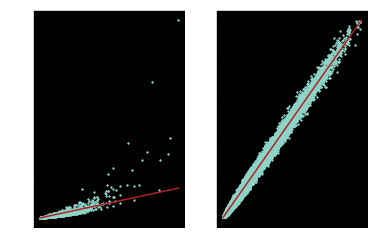

In [69]:
fig = plt.figure()
ax1 = fig.add_subplot(121)


d = G.node_degrees()

CL = np.outer(d, d)/(d.sum())
np.fill_diagonal(CL, 0)

ax1.scatter(CL.ravel(), w.ravel(), s = 1)
ax1.plot([0,CL.max()], [0, CL.max()], color = 'firebrick')

ax2 = fig.add_subplot(122)
b = x.sum(axis = 1)
CL_ = np.outer(b, b)/(b.sum())
np.fill_diagonal(CL_,0)
ax2.scatter(CL_.ravel(), x.ravel(), s = 1)
ax2.plot([0,x.max()], [0, x.max()], color = 'firebrick')

In [65]:
d = G.node_degrees().astype(int)
B = np.zeros((G.n, int(d.max())))
B[np.arange(G.n), d-1] = 1
B = B[:,B.sum(axis = 0) > 0]

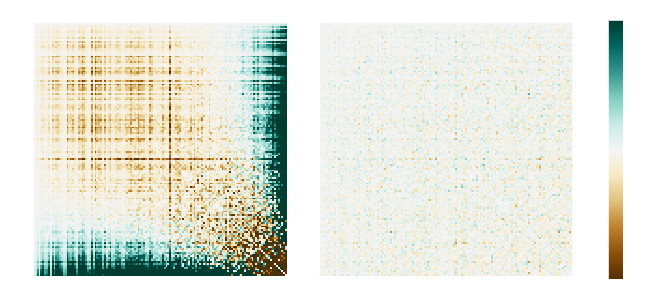

In [99]:
fig = plt.figure(figsize = (10, 6))
ax1 = fig.add_subplot(121)

err = (CL - w)/w.mean() 
v = np.mean(np.abs(err))
err = np.dot(np.dot(B.T, err), B)

im = ax1.imshow(err, cmap = "BrBG", vmin = -2, vmax = 2)
ax1.set(title = str(round(v, 2)))


ax2 = fig.add_subplot(122)
err = (CL_ - x) / x.mean()

v = np.mean(np.abs(err))
err = np.dot(np.dot(B.T, err), B)

im = ax2.imshow(err, cmap = "BrBG", vmin = -2, vmax = 2)
ax2.set(title = str(round(v, 2)))

plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax)